# Bayesian variable selection

The data for the variable selection in major depressive disorder was obtained from the Nathan Kline Institute - Rockland Sample. As we cannot share these data here, we use instead a simulated example.

In [ ]:
%load_ext autoreload
%autoreload 2

import os

# For JAX, we can use CPU (set SELECTED_DEVICE to empty (''), or one of the available GPUs)
SELECTED_DEVICE = '5'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [5]


In [ ]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)  # Do we need this here? -> it seems we do for the LML computations (otherwise NaNs get introduced), but not for performance

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax
import pandas as pd
import jax.scipy.special as jsp

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import sys
from blackjax import normal_random_walk

import bamojax
from bamojax.base import Node, Model
from bamojax.samplers import gibbs_sampler, mcmc_sampler
from bamojax.inference import SMCInference

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Distrax version:      ', dx.__version__)
print('BaMoJax version:      ', bamojax.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Distrax version:       0.1.5
BaMoJax version:       0.0.1
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


In [ ]:
DATA_DIR = '/home/maxhin/Documents/Code/SMC tutorial/BLR/data/Request all'
RESULTS_DIR = '/home/maxhin/Documents/Code/SMC tutorial/BLR'
FIGURES_DIR = 'figures'


def read_data(key, N=100, add_intercept=False):   
    key, key_X, key_y = jrnd.split(key, 3)
    beta_true = jnp.array([1.0, 0.0, 0.0, 4.3, -2.8])
    p = len(beta_true)    
    X = jrnd.normal(key_X, shape=(N, p))
    sigma_true = 0.7
    y = jnp.dot(X, beta_true) + sigma_true*jrnd.normal(key_y, shape=(N, ))
    labels = None
    if add_intercept:
        X = jnp.column_stack((jnp.ones((X.shape[0], )), X))  # add intercept! -> note that it doesn't do anything...
        if labels != None:
            labels.insert(0, 'Intercept')
    return X, y, labels

#

In [4]:
def boxplot_coefficients(ax, samples, ylabel, labels=None, sortbysize=True):
    
    mean = jnp.mean(samples, axis=0)
    p = len(mean)
    if sortbysize:
        ix = jnp.argsort(jnp.abs(mean))[::-1]
    else:
        ix = jnp.arange(p)
    samples = samples[:, ix]

    if labels == None:
        labels = p*['']
    elif labels == 'infer':
        labels = [r'$x_{{{:d}}}$'.format(i) for i in jnp.arange(p)[ix]]
    else:
        labels = [labels[i] for i in ix]

    ax.axhline(y=0.0, lw=0.5, color='k', ls='--')
    bp = ax.boxplot(samples,
                    patch_artist=True, 
                    tick_labels=labels,
                    boxprops=dict(facecolor='#FDB97D',
                                  linewidth=0.5),
                    showcaps=False,
                    medianprops=dict(color='k',
                                     linestyle='-',
                                     linewidth=0.5),
                    whiskerprops=dict(solid_capstyle='butt',
                                      linewidth=0.5),
                    showfliers=False)

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xlabel('Predictors')
    ax.set_ylabel(ylabel)
    return bp

#

Regular linear regression with Gaussian priors (ridge regression):

In [ ]:
key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)

print('Loading data')
X, y, labels = read_data(subkey, N=100, add_intercept=True)
p = X.shape[1]

def lin_reg_link_fn(beta, sigma, x):
    mu = jnp.dot(x, beta)
    return dict(loc=mu, scale=sigma)

#

LinearRegression = Model('BLR')
sigma = LinearRegression.add_node('sigma', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
beta = LinearRegression.add_node('beta', distribution=dx.Normal(loc=0., scale=1.), shape=(p, ))
x_node = LinearRegression.add_node('x', observations=X)
y_node = LinearRegression.add_node('y', observations=y, distribution=dx.Normal, parents=dict(beta=beta, sigma=sigma, x=x_node), link_fn=lin_reg_link_fn)

print('Gibbs conditionals: ')
LinearRegression.print_gibbs()

Loading data
Gibbs conditionals: 
Gibbs structure:
beta                : p(y | beta, x, sigma) p(beta)
sigma               : p(y | beta, x, sigma) p(sigma)


In [6]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(beta=normal_random_walk, sigma=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.05*jnp.eye(p)), sigma=dict(sigma=0.3))

gibbs = gibbs_sampler(LinearRegression, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)
final_state, lml, n_iter, final_info = smc_inference_loop(subkey, model=LinearRegression, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

for theta in ['beta', 'sigma']:
    print(f'Acceptance rate for {theta}: {jnp.mean(final_info.update_info[theta].is_accepted):0.3f}')

Acceptance rate for beta: 0.477
Acceptance rate for sigma: 0.234
CPU times: user 15.9 s, sys: 693 ms, total: 16.6 s
Wall time: 19.5 s


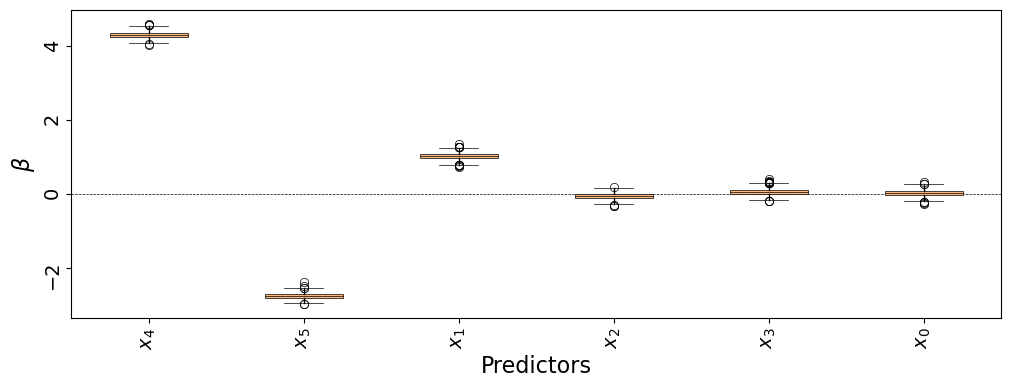

In [9]:
plt.figure(figsize=(12, 4))
_ = boxplot_coefficients(plt.gca(), final_state.particles['beta'], r'$\beta$', sortbysize=True, labels='infer')

Variable selection with the LN-CASS prior (regularizing coefficients towards zero; see Thomson et al., 2019):

In [10]:
mu_v = jsp.logit(0.2)
sigma_v = 1.0 

def lin_reg_link_fn(beta, sigma, x):
    mu = jnp.dot(x, beta)
    return dict(loc=mu, scale=sigma)

#

LNCASS = Model('SBLR')
sigma = LNCASS.add_node('sigma', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
tau = LNCASS.add_node('tau', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
lam = LNCASS.add_node('lam', dx.Transformed(dx.Normal(loc=mu_v*jnp.ones((p, )), scale=sigma_v*jnp.ones((p, ))), tfb.Sigmoid()))
beta = LNCASS.add_node('beta', distribution=dx.Normal, parents=dict(tau=tau, lam=lam), link_fn=lambda tau, lam: dict(loc=0.0, scale=(tau*lam)**2))
x_node = LNCASS.add_node('x', observations=X)
y_node = LNCASS.add_node('y', observations=y, distribution=dx.Normal, parents=dict(beta=beta, sigma=sigma, x=x_node), link_fn=lin_reg_link_fn)

LNCASS.print_gibbs()

Gibbs structure:
tau                 : p(beta | lam, tau) p(tau)
lam                 : p(beta | lam, tau) p(lam)
beta                : p(y | sigma, x, beta) p(beta | lam, tau)
sigma               : p(y | sigma, x, beta) p(sigma)


In [11]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(beta=normal_random_walk, 
                sigma=normal_random_walk, 
                lam=normal_random_walk, 
                tau=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.05*jnp.eye(p)), 
                      lam=dict(sigma=0.01*jnp.eye(p)), 
                      sigma=dict(sigma=0.5), 
                      tau=dict(sigma=0.5))

gibbs = gibbs_sampler(LNCASS, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)
final_state, lml, n_iter, final_info = smc_inference_loop(subkey, model=LNCASS, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

for theta in ['beta', 'sigma', 'lam', 'tau']:
    print(f'Acceptance rate for {theta}: {jnp.mean(final_info.update_info[theta].is_accepted):0.3f}')

Acceptance rate for beta: 0.329
Acceptance rate for sigma: 0.133
Acceptance rate for lam: 0.775
Acceptance rate for tau: 0.741
CPU times: user 16.3 s, sys: 632 ms, total: 16.9 s
Wall time: 12.5 s


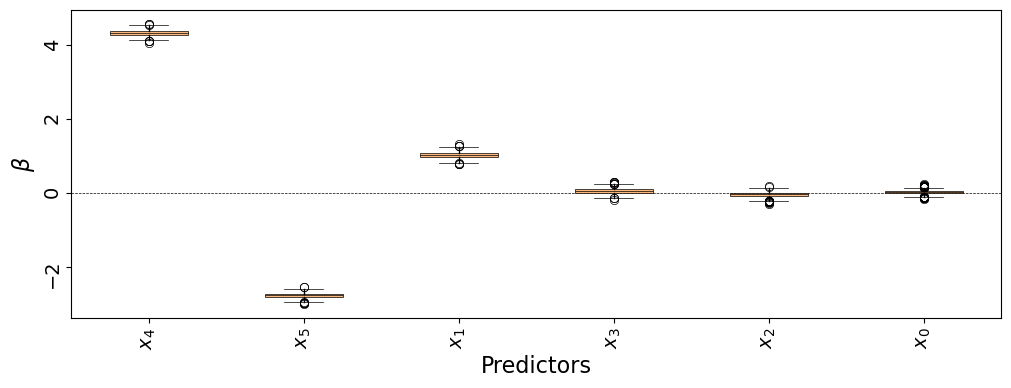

In [13]:
plt.figure(figsize=(12, 4))
_ = boxplot_coefficients(plt.gca(), final_state.particles['beta'], r'$\beta$', sortbysize=True, labels='infer')

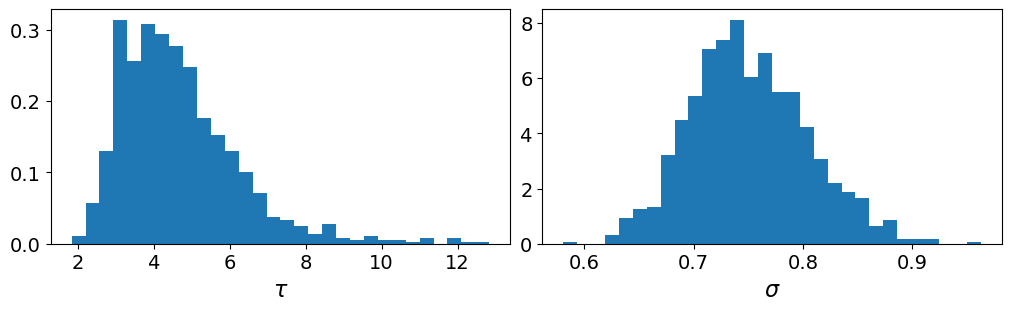

In [14]:
_, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 3))
for ax, theta in zip(axes, ['tau', 'sigma']):
    ax.hist(final_state.particles[theta], density=True, bins=30)
    ax.set_xlabel(fr'$\{theta}$')

Recall that true $\sigma=0.7$.

# Latent binary variables

See Schäfer & Chopin.

In [6]:
import jax.flatten_util
from blackjax.types import Array, ArrayLikeTree, ArrayTree, PRNGKey
from blackjax.base import SamplingAlgorithm
from typing import Callable


def generate_bernoulli_noise(rng_key: PRNGKey, position, theta):
    p, unravel_fn = jax.flatten_util.ravel_pytree(position)
    sample = jrnd.bernoulli(rng_key, shape=p.shape, p=theta)
    return unravel_fn(sample)

#
def bernoulli(theta: Array) -> Callable:
    def propose(rng_key: PRNGKey, position) -> ArrayTree:
        return generate_bernoulli_noise(rng_key, position, theta=theta)
    
    #
    return propose

#
def build_xor_step():
    def kernel(
        rng_key: PRNGKey, state, logdensity_fn: Callable, random_step: Callable
    ):
        def proposal_generator(key_proposal, position):
            move_proposal = jax.tree_util.tree_map(lambda x: x.astype(int), random_step(key_proposal, position)) 
            new_position = jax.tree_util.tree_map(jnp.bitwise_xor, position, move_proposal)
            return new_position

        inner_kernel = blackjax.mcmc.random_walk.build_rmh()
        return inner_kernel(rng_key, state, logdensity_fn, proposal_generator)

    return kernel

#  
def xor_step_random_walk(logdensity_fn: Callable, random_step: Callable) -> SamplingAlgorithm:

    kernel = build_xor_step()
    def init_fn(position: ArrayLikeTree, rng_key=None):
        del rng_key
        return blackjax.mcmc.random_walk.init(position, logdensity_fn)

    def step_fn(rng_key: PRNGKey, state):
        return kernel(rng_key, state, logdensity_fn, random_step)

    return SamplingAlgorithm(init_fn, step_fn)

#
def bernoulli_random_walk(logdensity_fn: Callable, theta):
    return xor_step_random_walk(logdensity_fn, bernoulli(theta))

#

Simulate data and determine MLE.

In [7]:
def least_squares(X, y):
    N, p = X.shape
    beta_mle = jnp.linalg.lstsq(X, y, rcond=None)[0]
    residuals = y - X @ beta_mle
    sigma2_mle = jnp.sum(residuals**2) / (N - p)
    return beta_mle, sigma2_mle

#

key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)
X, y, labels = read_data(subkey, N=100, add_intercept=True)
N, p = X.shape
print('X.shape:', X.shape)

beta_mle, sigma2_mle = least_squares(X, y)

print(beta_mle)
print(jnp.sqrt(sigma2_mle))

X.shape: (100, 6)
[ 0.01841078  1.0314066  -0.06733801  0.06472427  4.33146134 -2.77310075]
0.743545279978439


In [8]:
def lin_reg_link_fn(beta, gamma, sigma2, x):
    mu = jnp.dot(x, gamma*beta)
    return dict(loc=mu, scale=jnp.sqrt(sigma2))

#
def beta_gaussian_link_fn(loc, sigma2, v2, gamma, epsilon=1e-8):
    return dict(loc=loc, scale=sigma2 * v2 * gamma + epsilon)

#
w = 4.0
sigma2_hat = sigma2_mle
lmbda = sigma2_hat
v2 =10.0 / lmbda

LBV = Model('LBV')
sigma2 = LBV.add_node('sigma2', distribution=dx.Independent(tfd.InverseGamma(concentration=w/2, scale=lmbda*w/2), reinterpreted_batch_ndims=0))
theta = LBV.add_node('theta', distribution=dx.Beta(alpha=1.0, beta=1.0), shape=(p, ))
gamma = LBV.add_node('gamma', distribution=dx.Bernoulli, parents=dict(probs=theta))
beta = LBV.add_node('beta', distribution=dx.Normal, parents=dict(loc=0.0, sigma2=sigma2, v2=v2, gamma=gamma), link_fn=beta_gaussian_link_fn)
x_node = LBV.add_node('x', observations=X)
y_node = LBV.add_node('y', observations=y, distribution=dx.Normal, parents=dict(beta=beta, gamma=gamma, sigma2=sigma2, x=x_node), link_fn=lin_reg_link_fn)

LBV.print_gibbs()

Gibbs structure:
sigma2              : p(beta | v2_beta, gamma, sigma2, loc_beta) p(y | gamma, sigma2, beta, x) p(sigma2)
theta               : p(gamma | theta) p(theta)
gamma               : p(beta | gamma, v2_beta, sigma2, loc_beta) p(y | gamma, beta, sigma2, x) p(gamma | theta)
beta                : p(y | gamma, sigma2, beta, x) p(beta | v2_beta, gamma, sigma2, loc_beta)


### Gibbs

In [9]:
step_fns = dict(beta=normal_random_walk, 
                sigma2=normal_random_walk, 
                gamma=bernoulli_random_walk,
                theta=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.01*jnp.eye(p)),
                      sigma2=dict(sigma=0.1), 
                      gamma=dict(theta=0.2),
                      theta=dict(sigma=0.1))

gibbs = gibbs_sampler(LBV, step_fns=step_fns, step_fn_params=step_fn_params)

In [10]:
%%time
from bamojax.sampling import mcmc_inference_loop

key = jrnd.PRNGKey(1234)
key, subkey = jrnd.split(key)

gibbs_states, gibbs_info = mcmc_inference_loop(subkey, model=LBV, kernel=gibbs, num_samples=100_000, num_burn=100_000, num_chains=4, num_thin=100)

print('Inclusion probability:', jnp.mean(gibbs_states.position['gamma'], axis=jnp.array([1])))
print('beta:', jnp.mean(gibbs_states.position['beta'], axis=jnp.array([1])))

for var in gibbs_info.keys():
    print(f'{var}: {jnp.mean(gibbs_info[var].is_accepted):0.2f}')

Inclusion probability: [[0.495 1.    0.482 0.523 1.    1.   ]
 [0.468 1.    0.491 0.516 1.    1.   ]
 [0.46  1.    0.487 0.518 1.    1.   ]
 [0.478 1.    0.508 0.531 1.    1.   ]]
beta: [[ 1.51591994e-03  1.00448118e+00 -8.33861667e-03  9.76021950e-03
   4.32193497e+00 -2.74893789e+00]
 [ 3.31674742e-03  1.05684910e+00 -1.02371211e-02  1.06167023e-02
   4.35766655e+00 -2.77460684e+00]
 [ 3.30563362e-03  1.04652814e+00 -9.23017268e-03  9.26262287e-03
   4.32395193e+00 -2.78985616e+00]
 [ 2.61214625e-03  1.04642901e+00 -9.24595311e-03  8.32787558e-03
   4.33996247e+00 -2.75579684e+00]]
beta: 0.27
gamma: 0.39
sigma2: 0.66
theta: 0.48
CPU times: user 34.5 s, sys: 10.7 s, total: 45.1 s
Wall time: 41.3 s


### Gibbs-in-SMC

In [11]:
key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)

num_mcmc_steps = 300
num_particles = 1_000
num_chains = 4

final_state, lml, n_iter, final_info = smc_inference_loop(key=subkey, 
                                                          model=LBV, 
                                                          kernel=gibbs, 
                                                          num_particles=num_particles, 
                                                          num_mcmc_steps=num_mcmc_steps, 
                                                          num_chains=num_chains)

print('Acceptance rates')
for var in final_state.particles:
    ar = jnp.mean(final_info.update_info[var].is_accepted)
    print(f'{var}: {ar:0.3f}')

Acceptance rates
beta: 0.266
gamma: 0.379
sigma2: 0.550
theta: 0.490


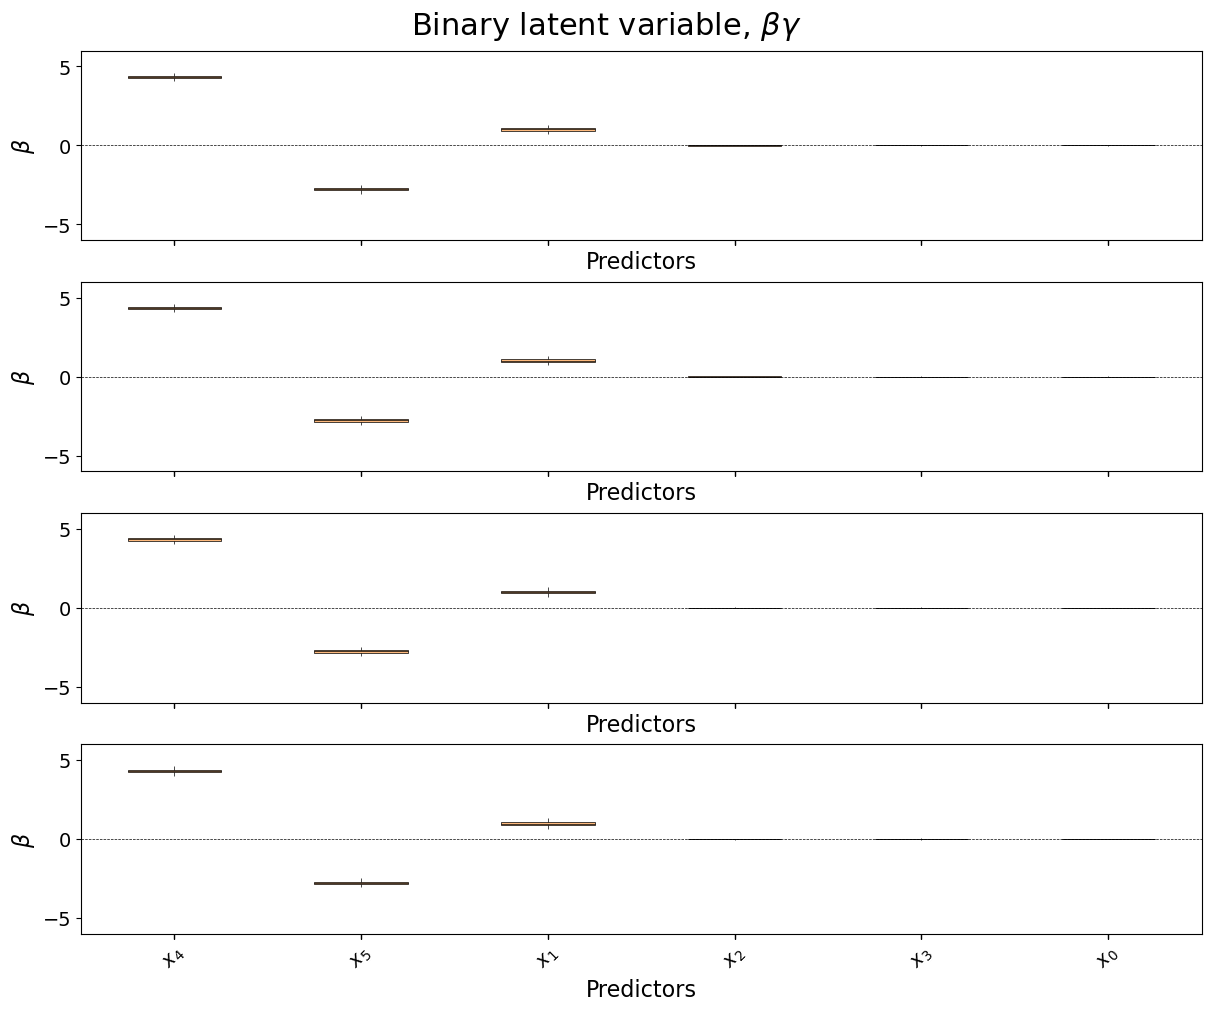

In [12]:
_, axes = plt.subplots(nrows=num_chains, ncols=1, sharex=True, sharey=True, constrained_layout=True, figsize=(12, 10))

for c, ax in enumerate(axes):
    if c == num_chains - 1:
        _ = boxplot_coefficients(ax, final_state.particles['beta'][c, ...], r'$\beta$', sortbysize=True, labels='infer')
    else:
        _ = boxplot_coefficients(ax, final_state.particles['beta'][c, ...], r'$\beta$', sortbysize=True)

for ax in axes:
    ax.set_ylim([-6, 6])

plt.suptitle(r'Binary latent variable, $\beta\gamma$');

In [12]:
print('Inclusion probability:', jnp.mean(final_state.particles['gamma'], axis=jnp.array([0, 1])))
print('beta:', jnp.mean(final_state.particles['beta'], axis=jnp.array([0, 1])))
print('Sigma2:', jnp.mean(final_state.particles['sigma2'], axis=jnp.array([0, 1])))

Inclusion probability: [0.49125 1.      0.533   0.52975 1.      1.     ]
beta: [ 1.87794060e-03  1.00663381e+00 -8.14743609e-03  8.07062438e-03
  4.33094341e+00 -2.76337927e+00]
Sigma2: 0.5816348319019742


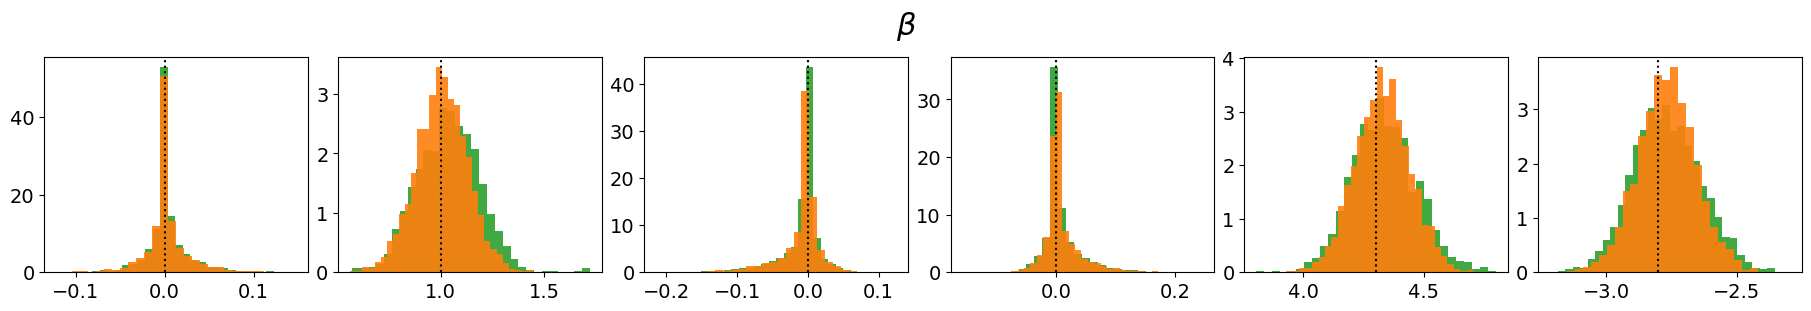

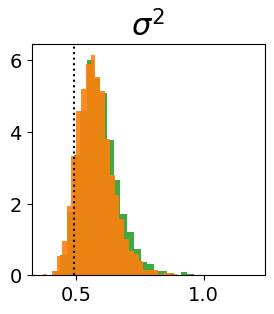

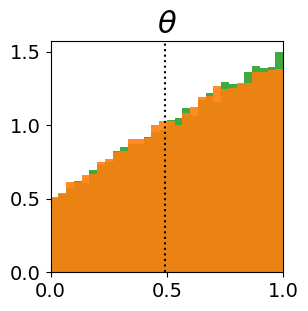

In [35]:
sigma_true = 0.7
beta_true = jnp.array([0.0, 1.0, 0.0, 0.0, 4.3, -2.8])

num_bins = 30

_, axes = plt.subplots(nrows=1, ncols=p, constrained_layout=True, figsize=(18, 3))
for j in range(p):
    axes[j].hist(gibbs_states.position['beta'][..., j].flatten(), density=True, bins=num_bins, color='tab:green', alpha=0.9)
    axes[j].hist(final_state.particles['beta'][..., j].flatten(), density=True, bins=num_bins, color='tab:orange', alpha=0.9)
    axes[j].axvline(x=beta_true[j], color='k', ls=':')
plt.suptitle(r'$\beta$')    

plt.figure(figsize=(3,3))
ax = plt.gca()
ax.hist(gibbs_states.position['sigma2'].flatten(), density=True, bins=num_bins, color='tab:green', alpha=0.9)
ax.hist(final_state.particles['sigma2'].flatten(), density=True, bins=num_bins, color='tab:orange', alpha=0.9)
ax.axvline(x=sigma_true**2, color='k', ls=':')
ax.set_title(r'$\sigma^2$');

plt.figure(figsize=(3,3))
ax = plt.gca()
ax.hist(gibbs_states.position['theta'].flatten(), density=True, bins=num_bins, color='tab:green', alpha=0.9)
ax.hist(final_state.particles['theta'].flatten(), density=True, bins=num_bins, color='tab:orange', alpha=0.9)
ax.axvline(x=sigma_true**2, color='k', ls=':')
ax.set_xlim([0.0, 1.0])
ax.set_title(r'$\theta$');

In [34]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

samples = [gibbs_states.position, final_state.particles]
names = ['Gibbs', 'Gibbs-in-SMC']

for s, name in zip(samples, names):
    print(f'Inference: {name}')
    for key in s.keys():
        ESS = effective_sample_size(s[key], chain_axis=0, sample_axis=1)
        print(f'({name}) {key} ESS: ')
        print(ESS)
        R = potential_scale_reduction(s[key], chain_axis=0, sample_axis=1)
        print(f'({name}) {key} PSRF: ')
        print(R)

Inference: Gibbs
(Gibbs) beta ESS: 
[3134.957096     98.88091756 1999.57602823 1419.43116027  145.14769896
  125.60112809]
(Gibbs) beta PSRF: 
[1.00014592 1.01147696 0.99983234 0.99993972 1.00717566 1.00959504]
(Gibbs) gamma ESS: 
[ 3629.81533041 14408.23996531  3618.64097551  3516.60124295
 14408.23996531 14408.23996531]
(Gibbs) gamma PSRF: 
[0.99995614        nan 0.99975454 0.99958934        nan        nan]
(Gibbs) sigma2 ESS: 
539.4353800885331
(Gibbs) sigma2 PSRF: 
1.0058691666381168
(Gibbs) theta ESS: 
[2948.3506189  3662.80102561 3082.4006683  3108.45566968 3651.66292873
 3521.0619626 ]
(Gibbs) theta PSRF: 
[1.000097   0.99979998 1.00021134 0.99963924 1.0003402  0.99963603]
Inference: Gibbs-in-SMC
(Gibbs-in-SMC) beta ESS: 
[3948.13236219 2023.94038767 3944.16992134 4116.64716303 3310.62198423
 3520.59607457]
(Gibbs-in-SMC) beta PSRF: 
[1.00009979 1.00707123 1.00023608 1.0001684  1.00070967 1.00110237]
(Gibbs-in-SMC) gamma ESS: 
[ 3744.59222545 14408.23996531  3917.45896712  4313.

ESS(beta) is much higher for SMC:

Gibbs: [3789.16585195  134.34247659 2839.06109098 1505.48186327  212.80718208
  130.82711115]

Gibbs-in-SMC: [4087.41141897 3424.48166468 4043.33204086 4040.25815845 3011.99158644
 3395.5501648 ]

Note that the high scores for $\beta$ in Gibbs are only when $\gamma=0$, so these are sampled from the prior!!!

Also, the ESS for $\sigma^2$ is 434.6 for Gibbs, but 3633.8 for SMC.

In [38]:
type(final_info)

blackjax.smc.base.SMCInfo

## todo

- Schäfer & Chopin's model definition
- Run on Bainter dataset; record PSRF and ESS
- Compare Gibbs vs SMC (see S&C for metrics?)